# Моделирование кривой процентных ставок

Цена обычной облигации без встроенных опционов определяется как дисконтированный денежный поток всех будущих выплат. Выплаты включают в себя купонные выплаты в течение срока (для купонных облигаций) и выплату номинала в дату погашения облигации. Таким образом справедливая цена такой облигации определяется следующей формулой:

$$NPV = \sum_{t=1}^{n} \frac{CF_t}{(1 + r)^t}$$

Для облигации с постоянным купоном $С$ иноминалом $N$ формула принимает следующий вид:

$$NPV = \sum_{t=1}^{n} \frac{C}{(1 + r)^t} + \frac{M}{(1 + n)^n}$$

В данной формуле используется единая ставка дисконтирования $R$, что в общем случае является грубой предпосылкой равенства доходности к погошению для инструментов с разным сроком погашения. Для более точной оценки облигаций необходимо учитывать структуру процентных ставок для долговых инструментов с разным сроком погашения и для дисконтирования каждого потока использовать соответствующую периоду денежного потока ставку, т.е. использовать следующую формулу:

$$NPV = \sum_{t=1}^{n} \frac{C}{(1 + r_t)^t} + \frac{M}{(1 + r_n)^n}$$

Если довыплаты купона остается меньше целового периода, тоцену можно определить последующей формуле:

$$NPV = \sum_{t=1}^{n} \frac{C}{(1 + r_t)^v \cdot (1 + r_t)^{t-1}} + \frac{M}{(1 + r_n)^v \cdot (1 + r_n)^{n-1}}$$

, где

$$v = \frac{число \ дней \ до \ следующего \ купона}{число \ дней \ в \ периоде}$$

В данной заметке я рассмотрю несколько способов моделирования кривой процентных ставок, которая будет использоваться для получения ставок дисконтирования будущих денежных потоков в оценке одной и той же облигации с известной ценой. Интересно посмотреть как точно разные методы позволяют оценить облигацию.

### Общая постановка задачи. Анализ исходных данных.

Имется данные по ценам 44 государственных облигаций Германии с различным сроком погашения. Все бумаги в одной валюте - EUR. Дата выгрузки данных - 18 октября 2007. В выборке имеются как купонные, так и бескупонные бумаги. Все купонные бумаги с одниковой периодичностью выплат купонов - один раз в год, даты купонных выплат для некоторых бумаг отличаются.

Исходные данные представлены в Excel документе, на первой странице ("Бумаги") предствлены общие данные по котировкам бумаг. Поля данных включают следующие:

1. Код бумаги
2. Чистая цена
3. Величина накопленного купонного дохода (НКД)
4. Ставка купона
5. Дата погашения
6. Количество рабочих дней до погашения

Данные по периодичности купонных платежей представлены на второй странице ("Купонная матрица") в виде матрицы купонных выплат для представленных бумаг. Формат следующий: в колонке "B" представлены названия бумаг, в этой же строке даты выплат, под ними размер выплат.

Загружаем исходные данные:

In [258]:
%matplotlib inline

import seaborn
seaborn.mpl.rcParams['figure.figsize'] = (7.0, 4.0)
seaborn.mpl.rcParams['savefig.dpi'] = 100

import numpy as np
import pandas as pd
import pyexcel_xls as pe


sheets = pe.get_data('data/bonds.xls')

current_date = pd.datetime(2007, 10, 18).date()

def read_bonds_data(sheets, bonds_sheet = 'Бумаги', bonds_start = 6):
    bonds_data = {
        'code' : [],
        'net_price' : [], 
        'cd' : [], 
        'coupon_rate' : [],
        'maturity_date' : [],
        'maturity_days' : []
    }
    for row in sheets[bonds_sheet][bonds_start:]:
        if (len(row) > 0):
            bonds_data['code'].append(row[1])
            bonds_data['net_price'].append(row[2])
            bonds_data['cd'].append(row[3])
            bonds_data['coupon_rate'].append(row[5])
            bonds_data['maturity_date'].append(row[11])
            bonds_data['maturity_days'].append(row[12])
    return pd.DataFrame(bonds_data)

def read_coupon_matrix(sheets, cf_matrix_sheet = 'Купонная матрица', matrix_start = 2):
    current_code=None
    cash_flow=None
    date=True
    data = {}
    for row in sheets[cf_matrix_sheet][matrix_start:]:
        if (len(row) > 0):
            if date:
                current_code = row[1]
                cash_flow = {
                    'date' : [],
                    current_code : []
                }
                cash_flow.update({'date' : row[2:]})
                date = False
            else:
                date = True
                cash_flow.update({current_code : row[2:]})
                s = pd.Series(cash_flow[current_code], index=cash_flow['date'])
                df = pd.DataFrame({
                        'date' : cash_flow['date'],
                        'value' : pd.Series(cash_flow[current_code], index=cash_flow['date'])
                    })
                data.update({current_code : df})
                
    return data

coupon_matrix = read_coupon_matrix(sheets)
bonds_df = read_bonds_data(sheets)

class Payment():
    
    def __init__(self, date, days, value):
        self.date = date
        self.days = days
        self.value = value

def create_cf(bond_payments, current_date):
    payments = []
    bond_payments['days'] = (bond_payments['date'] - current_date).dt.days
    for index, row in bond_payments.iterrows():
        payments.append(Payment(row['date'], row['days'], row['value']))
    return payments


In [259]:
bonds_df[bonds_df['code'] == 'EC155787 Corp']

,cd,code,coupon_rate,maturity_date,maturity_days,net_price
10,1.364754,EC155787 Corp,4.5,2009-07-04,625,100.515


In [303]:

class Bond():
    
    def __init__(self, code, coupon_rate, payments_per_year, payments, price, accrued_interest):
        self.code = code
        self.coupon_rate = coupon_rate
        self.payments_per_year = payments_per_year
        self.payments = payments
        self.price = price
        self.accrued_interest = accrued_interest
        
    def calc_price(self, rates):
        first_payment = self.payments[0]
        v = float(first_payment.days) / float(364 / self.payments_per_year) if self.payments_per_year > 0 else 0.0
        npv = 0.0
        i = 1
        for p in self.payments:
            rate = rates[i-1]
            npv += float(p.value) / (pow((1 + rate), v)*pow((1 + rate), i - 1))
            i += 1
        return npv / 1000000
    
    def macauley_duration(self, rates):
        
    
    def tot_price(self):
        return float(self.price + self.accrued_interest) / 100.0
        
    def print_info(self):
        print("-------------------------------------------")
        print("BOND CODE:           '%s'" % self.code)
        print("-------------------------------------------")
        print("DAYS TO MATURITY:    %d" % self.payments[-1].days)
        print("PAYMENTS PER YEAR:   %d" % self.payments_per_year)
        print("COUPON RATE:         %f" % self.coupon_rate)
        print("-------------------------------------------")
        print("EXPECTED PAYMENTS:")
        count = 1
        for p in self.payments:
            print("%3d. %s (%5d days) %d" % (count, p.date, p.days, p.value))
            count += 1
        
        print("-------------------------------------------")
        
payments = create_cf(coupon_matrix['EC155787 Corp'], current_date)
bond = Bond('EC155787 Corp', 4, 1, payments, 100, 1)
            

Посмотрим облигации с какими сроками погашения представлены в выборке.

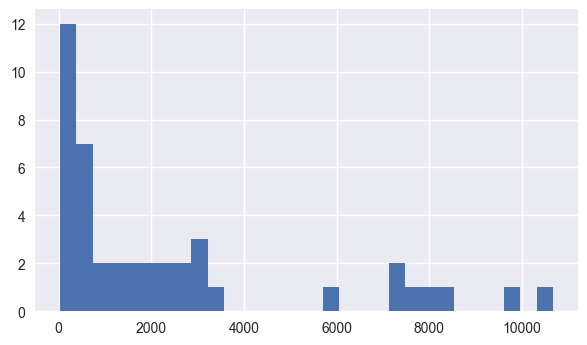

In [292]:
bonds_df['maturity_days'].hist(bins=30)

Полученная матрица содержит выплаты по инструментам в каждую заданную дату. Дата учитывается в матрице, если хотя бы по одному инструменту в эту дату есть платежь. Для инструментов, у которых в эту дату платежей нет, в матрице будет значение 0. Таким образом, если задать вектор $a$ содержащий дисконтирующий фактор для каждой даты, то умножение матрицы на этот вектор даст вектор цен инструментов.

### Модель кривой процентных ставок.

Подготовим данные по бумагам.

In [318]:
bonds = []
for i, bond_data in bonds_df.iterrows():
    bond_code = bond_data['code']
    payments = create_cf(coupon_matrix[bond_code], current_date)
    coupon_rate = float(bond_data['coupon_rate']) / 100.0 
    # TODO костыль
    payments_per_year = 1 if coupon_rate > 0 else 0
    price = bond_data['net_price']
    accrued_interest = bond_data['cd']
    bond = Bond(bond_code, coupon_rate, payments_per_year, payments, price, accrued_interest)
    bonds.append(bond)

#### Метод Нельсона-Зигеля. 

Задаем кривую ставок в параметрическом виде и оптимизируем по среднеквадратичной ошибке оценки имеющихся облигаций.

# $r(\tau) = \beta_0 + (\beta_1 + \beta_2) (1 - e^{-\tau / a})\frac{a}{\tau} - \beta_2 e^{-\tau / a}$

In [316]:
from scipy.optimize import minimize

class NelsonZigelModel():
    
    def __init__(self):
        self.a = 1.0
        self.params = np.array([1, 1, 1])
        
    def error_func(self, bonds):
        def error(params):
            error_value = 0.0
            for bond in bonds:
                price = self.evaluate(params, bond)
                error_value += np.power(price - bond.tot_price(), 2)
            return error_value
        return error                  
        
    def fit(self, bonds):
        result = minimize(
            self.error_func(bonds), self.params, options={'disp': True, 'maxiter': 1000}
        )
        self.params = result.x                                           
        return self
        
    def get_rates(self, params, days):
        rates = []
        for d in days:
            nz = self.nelson_zigel(params, d)
            rates.append(nz)
        return rates
            
    def nelson_zigel(self, params, d):
        return params[0] + (params[1] + params[2]) * (1 - np.power(np.e, (-d / self.a))) * (self.a / d) - params[2] * np.power(np.e, (-d / self.a))
            
    def evaluate(self, params, bond):
        # запрашиваем у модели кривой ставок значения ставок для платежей по этому бонду
        rates = self.get_rates(params, [p.days for p in bond.payments])
        return bond.calc_price(rates)

Optimization terminated successfully.
         Current function value: 0.003124
         Iterations: 9
         Function evaluations: 110
         Gradient evaluations: 22


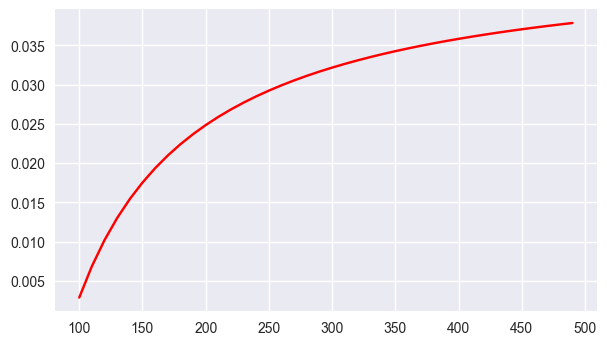

In [319]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

import seaborn
seaborn.mpl.rcParams['figure.figsize'] = (7.0, 4.0)
seaborn.mpl.rcParams['savefig.dpi'] = 100

nz_model = NelsonZigelModel().fit(bonds)

days = [i for i in range(100, 500, 10)]
rates = model.get_rates(nz_model.params, days)

plt.plot(days, rates, 'r')